In [1]:
import json 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
with open(r"C:\Users\BHernandez\OneDrive - SMA, Inc\Documents\VS Code\Other\1631809090_1481053515_ultimate_challenge_3_\ultimate_challenge\ultimate_data_challenge.json") as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(data)

df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [5]:
# Create target feature
df['active'] = 0
cutoff = df['last_trip_date'].max() - pd.DateOffset(months=1)

df['active'].loc[df.last_trip_date >= cutoff] = 1

c:\Users\BHernandez\venv1\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Examine Missing Values

In [6]:
df.avg_rating_of_driver.describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [7]:
# Fill missing reviews of drives with median since data is skewed
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.median())

In [8]:
df.avg_rating_by_driver.describe()

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [9]:
# Fill missing reviews by drivers with median since data is skewed
df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.median(), inplace=True)

In [10]:
df.ultimate_black_user = df['ultimate_black_user'].astype('int')

In [11]:
# Drop missing phone type values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  int32         
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
 12  active                  49604 non-null  int64 

### Visualize Data

<AxesSubplot:>

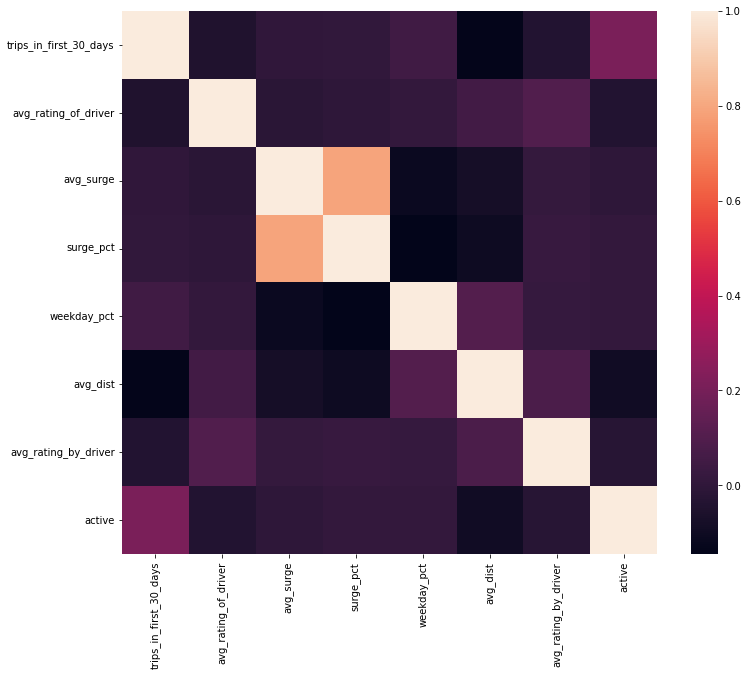

In [12]:
plt.figure(figsize=(12,10))
sns.heatmap(df.drop(columns=['city', 'phone', 'signup_date', 'last_trip_date', 'ultimate_black_user']).corr())

In [49]:
df[['avg_dist', 'active']].corr()

,avg_dist,active
avg_dist,1.000000,-0.092014
active,-0.092014,1.000000


### Encode catagorical variables

In [13]:
df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True, dtype=int)

In [14]:
# Fraction of drivers that have been retained after six months
retained = df['active'].mean()
print('Percent of drivers retained:', retained)

Percent of drivers retained: 0.37640109668575117


# Modeling

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

In [17]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['active', 'signup_date', 'last_trip_date']), df.active, test_size=0.7, random_state=42)

##### K Nearest Neighbors

In [23]:
knn = KNeighborsClassifier()
params = {'n_neighbors':[3,6,9,12,15,17]}

clf = GridSearchCV(knn, params, cv=5, scoring='f1')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 6, 9, 12, 15, 17]}, scoring='f1')

In [24]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [25]:
print(clf.cv_results_['params'])
print(clf.cv_results_['mean_test_score'])

[{'n_neighbors': 3}, {'n_neighbors': 6}, {'n_neighbors': 9}, {'n_neighbors': 12}, {'n_neighbors': 15}, {'n_neighbors': 17}]
[0.62440568 0.59287003 0.63314589 0.61321237 0.63789812 0.63387653]


In [26]:
knn = KNeighborsClassifier(15)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [27]:
knn_pred = knn.predict(X_test)
print("K Nearest Neighbors test accuracy:", knn.score(X_test, y_test))

K Nearest Neighbors test accuracy: 0.7449817124096421


In [41]:
print(classification_report(y_test, knn_pred))
print(confusion_matrix(y_test, knn_pred))
print(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80     21657
           1       0.69      0.59      0.64     13066

    accuracy                           0.74     34723
   macro avg       0.73      0.71      0.72     34723
weighted avg       0.74      0.74      0.74     34723

[[18125  3532]
 [ 5323  7743]]
0.8004291382289712


The Knn model seems to be good at predicting users who will not be retained, but struggles with predicting users who will be retained. The recall of 0.59 for retained users is particularly low.

### Random Forest

In [66]:
RFC = RandomForestClassifier()

RFC_params = {'n_estimators':[10, 12, 16, 20,
                              26, 33, 42, 54,
                              69, 88, 112,
                              143, 183, 233,
                              297, 379],
              'criterion':['gini', 'entropy'],
              'random_state':[42]}

RFC_clf = GridSearchCV(RFC, param_grid=RFC_params, cv=5, scoring='f1')
RFC_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [10, 12, 16, 20, 26, 33, 42, 54, 69,
                                          88, 112, 143, 183, 233, 297, 379],
                         'random_state': [42]},
             scoring='f1')

In [33]:
# Function that does exactly the same thing as the previous cell
def results(cv_results):
    res_dict = {'mean_test_score':cv_results['mean_test_score'], 'params':cv_results['params']}
    res_df = pd.DataFrame(res_dict)
    res_df.sort_values(by='mean_test_score', ascending=False, inplace=True)
    print(res_df.head())

In [ ]:
results(RFC_clf.cv_results_)

In [29]:
RFC = RandomForestClassifier(criterion='entropy', n_estimators=297)

RFC.fit(X_train, y_train)
RFC_pred = RFC.predict(X_test)

print("Random Forest accuracy score:", RFC.score(X_test, y_test))

Random Forest accuracy score: 0.7585174092100337


In [42]:
print(classification_report(y_test, RFC_pred))
print(confusion_matrix(y_test, RFC_pred))
print(roc_auc_score(y_test, RFC.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81     21657
           1       0.68      0.67      0.68     13066

    accuracy                           0.76     34723
   macro avg       0.74      0.74      0.74     34723
weighted avg       0.76      0.76      0.76     34723

[[17583  4074]
 [ 4311  8755]]
0.8235417160048726


The random forest model performs better than the KNN model, but seems to have the same difficulty with classifying retained users.

### SVM Classifier

In [18]:
svm = SVC()

svm_params = {'C':[0.1, 1, 5, 10, 20], 'gamma':['scale', 'auto']}
svm_clf = GridSearchCV(svm, param_grid=svm_params, cv=5, scoring='f1')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

svm_clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 5, 10, 20], 'gamma': ['scale', 'auto']},
             scoring='f1')

In [28]:
results(svm_clf.cv_results_)

   mean_test_score                       params
8         0.666591  {'C': 20, 'gamma': 'scale'}
9         0.666583   {'C': 20, 'gamma': 'auto'}
4         0.665576   {'C': 5, 'gamma': 'scale'}
6         0.665340  {'C': 10, 'gamma': 'scale'}
5         0.665118    {'C': 5, 'gamma': 'auto'}


In [44]:
svm = SVC(C=20, gamma='scale', probability=True)
svm.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

print('SVM classifier accuracy:', svm.score(X_test_scaled, y_test))

SVM classifier accuracy: 0.7674740085822077


In [46]:
svm_pred = svm.predict(X_test_scaled)

print(classification_report(y_test, svm_pred))
print(confusion_matrix(y_test, svm_pred))
print(roc_auc_score(y_test, svm.predict_proba(X_test_scaled)[:, 1]))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     21657
           1       0.72      0.62      0.67     13066

    accuracy                           0.77     34723
   macro avg       0.76      0.74      0.74     34723
weighted avg       0.76      0.77      0.76     34723

[[18512  3145]
 [ 4929  8137]]
0.8113063798533078


### Gradient Boosting

In [20]:
GB = GradientBoostingClassifier()

GB_params = {'n_estimators':[50, 100, 150], 'max_depth':[3, 10], 'random_state':[42]}

GB_clf = GridSearchCV(GB, param_grid=GB_params, cv=5, scoring='f1')

GB_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [3, 10], 'n_estimators': [50, 100, 150],
                         'random_state': [42]},
             scoring='f1')

In [34]:
results(GB_clf.cv_results_)

   mean_test_score                                             params
2         0.699708  {'max_depth': 3, 'n_estimators': 150, 'random_...
1         0.699288  {'max_depth': 3, 'n_estimators': 100, 'random_...
0         0.690735  {'max_depth': 3, 'n_estimators': 50, 'random_s...
4         0.683515  {'max_depth': 10, 'n_estimators': 100, 'random...
3         0.682226  {'max_depth': 10, 'n_estimators': 50, 'random_...


In [35]:
GB = GradientBoostingClassifier(max_depth=3, n_estimators=150)

GB.fit(X_train, y_train)

GB_pred = GB.predict(X_test)

print('GB test accuracy:', GB.score(X_test, y_test))

GB test accuracy: 0.7848688189384557


In [47]:
print(classification_report(y_test, GB_pred))
print(confusion_matrix(y_test, GB_pred))
print(roc_auc_score(y_test, GB.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83     21657
           1       0.74      0.67      0.70     13066

    accuracy                           0.78     34723
   macro avg       0.77      0.76      0.77     34723
weighted avg       0.78      0.78      0.78     34723

[[18548  3109]
 [ 4361  8705]]
0.8515010610899243


So far the Gradient Boosted model has the best performace

# Conclusions

The best predictive model is the Gradient Boosted model. This model retruned the highest AUC and F1 score. The model also had the highest accuracy out of all the models, and tied for the highest recall for retained users, which is what most of the models struggled with. 

The Gradient Boosted model is good at predicting users who will not be retained in 6 months, with a percison of 81% (indicating that 81% of the positive predictions are correct) and a recall of 86% (indicating that 86% of the positive samples were predicted correctly). Where the model struggles is with predicting users that will be retained after 6 months, with a precison of 74% (indicating that 74% of the positive predictions are correct) and a recall of 67% (indicating that only 67% of the positive samples were predicted correctly). What this ultimately means is that this model could be effectively used to predict if a user will not be retaiend, allowing Ultimate the chance to entice them to stay, but should not be relied on to determine if a user is likely to be active after 6 months. 


The strongest predictors of whether a user remains active after 6 months are the number of trips taken in the first 30 days and the average distance a user's trips are. The number of trips in the first 30 days had the strongest positive correlation with user retention, and the average trip distance was the only feature that had a negative correlation with user retention. This indicates that users who use Ultimate for convenience, paying for cheeper rides to get around town, are more likely to be retained than users who use Ultimate for longer trips every once in a while (like trips to the airport). Based on this information I would recommend that Ultimate try to promote itself more in urban environments, where the trips will be shorter in distance, and the price of a trip is less daunting to a user.